In [7]:
# Part 1: Data processing
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV file
data = pd.read_csv('16_3heads.csv')

# Extract embeddings (X) and true_value (y) from the data
X = data.drop('True_value', axis=1).values
y = data['True_value'].values

# Standardize the embeddings (mean=0, std=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state = 45)

# Convert embeddings and labels to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create custom Dataset for positive and negative pairs
class SiameseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        anchor_emb, anchor_label = self.X[index], self.y[index]
        positive_mask = (self.y == anchor_label)
        negative_mask = ~positive_mask

        # Get positive and negative embeddings and labels
        positive_embeddings = self.X[positive_mask]
        negative_embeddings = self.X[negative_mask]

        # Choose a random positive pair and a random negative pair
        pos_idx = np.random.choice(len(positive_embeddings))
        neg_idx = np.random.choice(len(negative_embeddings))

        pos_emb = positive_embeddings[pos_idx]
        neg_emb = negative_embeddings[neg_idx]

        # Convert to torch tensors
        anchor_emb = torch.tensor(anchor_emb)
        pos_emb = torch.tensor(pos_emb)
        neg_emb = torch.tensor(neg_emb)

        return (anchor_emb, pos_emb), (anchor_emb, neg_emb)

# Create DataLoader for training
batch_size = 32
train_dataset = SiameseDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing
test_dataset = SiameseDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
# Part 2: Building the Siamese Network
import torch.nn as nn
import torch.nn.functional as F

# Siamese Network Module Definition
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [9]:
# Part 3: Training the Siamese Network
import torch.optim as optim

# Custom contrastive loss with Euclidean distance
class ContrastiveLossEuclidean(torch.nn.Module):
    def __init__(self, margin):
        super(ContrastiveLossEuclidean, self).__init__()
        self.margin = margin

    def forward(self, pos_distance, neg_distance):
        loss = (pos_distance).pow(2).mean() + F.relu(self.margin - neg_distance).pow(2).mean()
        return loss

# Create the Siamese Network
input_dim = X_train_tensor.shape[1]
hidden_dim = 8  # Adjust the hidden dimension as needed
output_dim = 16 # The final dimension of the learned representations
siamese_net = SiameseNetwork(input_dim, hidden_dim, output_dim)

# Initialize the custom contrastive loss with Euclidean distance
margin = 0.5  # You can adjust this margin based on your data and task
criterion = ContrastiveLossEuclidean(margin)

# Training loop
num_epochs = 200
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    total_loss = 0

    for batch in train_loader:
        pairs_pos, pairs_neg = batch
        anchors_pos, pos_emb = pairs_pos
        anchors_neg, neg_emb = pairs_neg

        anchor_output_pos = siamese_net(anchors_pos)
        anchor_output_neg = siamese_net(anchors_neg)
        pos_distance = F.pairwise_distance(anchor_output_pos, pos_emb, p=2)
        neg_distance = F.pairwise_distance(anchor_output_neg, neg_emb, p=2)

        loss = criterion(pos_distance, neg_distance)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(total_loss / len(train_loader))
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss / len(train_loader)}")

    # Calculate testing accuracy at each epoch
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch in test_loader:
            pairs_pos, pairs_neg = batch
            anchors_pos, pos_emb = pairs_pos
            anchors_neg, neg_emb = pairs_neg

            anchor_output_pos = siamese_net(anchors_pos)
            anchor_output_neg = siamese_net(anchors_neg)
            pos_distance = F.pairwise_distance(anchor_output_pos, pos_emb, p=2)
            neg_distance = F.pairwise_distance(anchor_output_neg, neg_emb, p=2)

            pos_similarity = F.pairwise_distance(anchor_output_pos, pos_emb, p=2)
            neg_similarity = F.pairwise_distance(anchor_output_neg, neg_emb, p=2)

            correct_test += ((pos_similarity < margin).sum() + (neg_similarity >= margin).sum()).item()
            total_test += len(pos_similarity) + len(neg_similarity)

        test_accuracy = correct_test / total_test
        test_accuracies.append(test_accuracy)


C:\Users\prerk\AppData\Local\Temp\ipykernel_1252\838715946.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor_emb = torch.tensor(anchor_emb)
C:\Users\prerk\AppData\Local\Temp\ipykernel_1252\838715946.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_emb = torch.tensor(pos_emb)
C:\Users\prerk\AppData\Local\Temp\ipykernel_1252\838715946.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_emb = torch.tensor(neg_emb)


Epoch 1/200, Train Loss: 17.31804676055908
Epoch 2/200, Train Loss: 12.53757438659668
Epoch 3/200, Train Loss: 16.977468490600586
Epoch 4/200, Train Loss: 14.552988433837891
Epoch 5/200, Train Loss: 15.312651252746582
Epoch 6/200, Train Loss: 15.428319931030273
Epoch 7/200, Train Loss: 19.067305183410646
Epoch 8/200, Train Loss: 15.742814254760741
Epoch 9/200, Train Loss: 14.399503707885742
Epoch 10/200, Train Loss: 21.151125335693358
Epoch 11/200, Train Loss: 14.732491874694825
Epoch 12/200, Train Loss: 14.573101425170899
Epoch 13/200, Train Loss: 15.431553649902344
Epoch 14/200, Train Loss: 14.649923133850098
Epoch 15/200, Train Loss: 16.96618309020996
Epoch 16/200, Train Loss: 15.137365531921386
Epoch 17/200, Train Loss: 17.888256072998047
Epoch 18/200, Train Loss: 13.244929695129395
Epoch 19/200, Train Loss: 16.418577575683592
Epoch 20/200, Train Loss: 15.891202545166015
Epoch 21/200, Train Loss: 16.82654151916504
Epoch 22/200, Train Loss: 14.0876953125
Epoch 23/200, Train Loss: 13

Epoch 200/200, Test Accuracy: 0.5031847133757962
Confusion Matrix:
[[155   2]
 [  3 154]]


C:\Users\prerk\AppData\Local\Temp\ipykernel_1252\838715946.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor_emb = torch.tensor(anchor_emb)
C:\Users\prerk\AppData\Local\Temp\ipykernel_1252\838715946.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_emb = torch.tensor(pos_emb)
C:\Users\prerk\AppData\Local\Temp\ipykernel_1252\838715946.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_emb = torch.tensor(neg_emb)


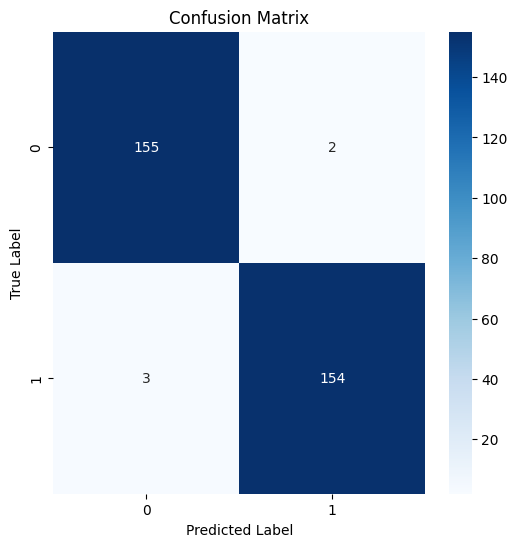

In [10]:
# Part 4: Confusion Matrix for the true and predicted values
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Testing loop (evaluate on the test dataset) for the last epoch
correct_test = 0
total_test = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        pairs_pos, pairs_neg = batch
        anchors_pos, pos_emb = pairs_pos
        anchors_neg, neg_emb = pairs_neg

        anchor_output_pos = siamese_net(anchors_pos)
        anchor_output_neg = siamese_net(anchors_neg)
        pos_distance = F.pairwise_distance(anchor_output_pos, pos_emb, p=2)
        neg_distance = F.pairwise_distance(anchor_output_neg, neg_emb, p=2)

        # Calculate test accuracy
        pos_similarity = F.pairwise_distance(anchor_output_pos, pos_emb, p=2)
        neg_similarity = F.pairwise_distance(anchor_output_neg, neg_emb, p=2)

        correct_test += ((pos_similarity < margin).sum() + (neg_similarity >= margin).sum()).item()
        total_test += len(pos_similarity) + len(neg_similarity)

        # Store predicted and true labels for the last epoch
        predicted_labels.extend((pos_similarity >= margin).cpu().numpy().tolist())
        predicted_labels.extend((neg_similarity < margin).cpu().numpy().tolist())
        true_labels.extend([1] * len(pos_similarity))
        true_labels.extend([0] * len(neg_similarity))

test_accuracy = correct_test / total_test
test_accuracies.append(test_accuracy)
print(f"Epoch {num_epochs}/{num_epochs}, Test Accuracy: {test_accuracy}")

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Graphical representation of confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [11]:
print(predicted_labels)
print(len(predicted_labels))

# print(y_test)
# print(len(y_test))

print(true_labels)
print(len(true_labels))

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Convert the predicted labels and true labels to numpy arrays
predicted_labels_np = np.array(predicted_labels)
true_labels_np = np.array(true_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels_np, predicted_labels_np)
precision = precision_score(true_labels_np, predicted_labels_np)
recall = recall_score(true_labels_np, predicted_labels_np)
f1 = f1_score(true_labels_np, predicted_labels_np)
auc = roc_auc_score(true_labels_np, predicted_labels_np)

print("Testing Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Area Under Curve (AUC):", auc)


Testing Accuracy: 0.9840764331210191
Precision: 0.9871794871794872
Recall: 0.9808917197452229
F1 Score: 0.9840255591054313
Area Under Curve (AUC): 0.9840764331210191
